Data Head:
         id  weight  temperature  movement       eating sociability  \
0  cow_0001     402         38.4  moderate  chewing cud     neutral   
1  cow_0002     451         38.8  moderate      grazing      social   
2  cow_0003     613         37.6       low  chewing cud    isolated   
3  cow_0004     543         39.0  moderate      grazing     neutral   
4  cow_0005     313         38.4       low  chewing cud     neutral   

   rumination  heartrate monitor_status  age           health  
0         314         50    operational    4          healthy  
1         513         77    operational    4          healthy  
2         575         99    operational    4  needs attention  
3         120         48    operational    4  needs attention  
4         554         83    operational    1  needs attention  

Data Shape: (3000, 11)

Class Distribution:
health
needs attention    1638
healthy            1362
Name: count, dtype: int64

Predictor Columns:
['weight', 'temperature', 'movem

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

Classification Report:
                 precision    recall  f1-score   support

        healthy       0.65      0.68      0.67       272
needs attention       0.73      0.69      0.71       328

       accuracy                           0.69       600
      macro avg       0.69      0.69      0.69       600
   weighted avg       0.69      0.69      0.69       600


Confusion Matrix:


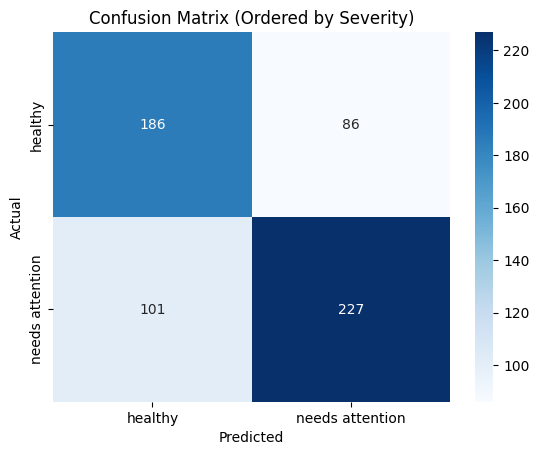

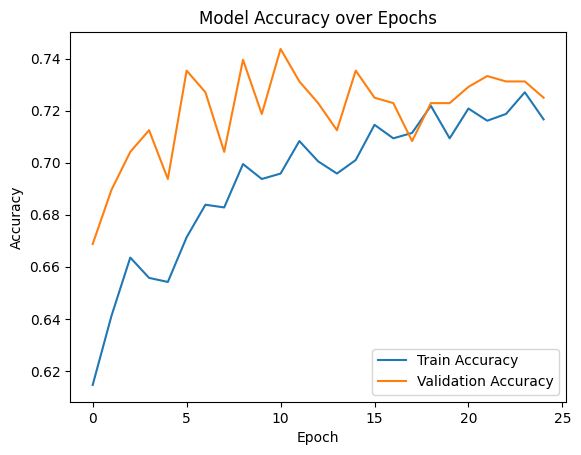

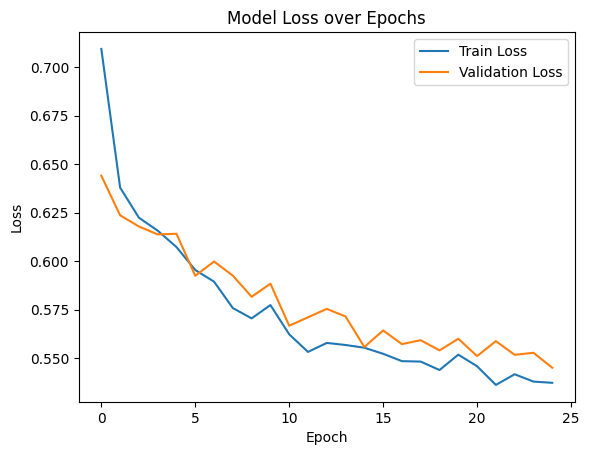

In [23]:
# Cow Health Neural Network Classifier
# ------------------------------------------------------
# 1. Load libraries and dataset
#!pip install scikit-learn
#!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

# Load dataset
df = pd.read_csv("fake_cow_dataset_binary_health.csv")

# ------------------------------------------------------
# 2. Initial data exploration
print("Data Head:")
print(df.head())
print("\nData Shape:", df.shape)
print("\nClass Distribution:")
print(df['health'].value_counts())

# ------------------------------------------------------
# 3. Feature selection
# Add Stress Index and Movement × Eating Interaction to the X DataFrame

df['stress_index'] = (df['heartrate'] * df['temperature']) / (df['rumination'] + 1)
df['movement_eating_combo'] = df['movement'] + '_' + df['eating']

X = df.drop(columns=['health', 'id'])
y = df['health']



print("\nPredictor Columns:")
print(X.columns.tolist())
print("\nTarget:")
print(y.name)

# ------------------------------------------------------
# 4. Preprocessing pipeline
# Updated numeric and categorical features lists
numeric_features = ['weight', 'temperature', 'rumination', 'heartrate', 'stress_index']
categorical_features = ['movement', 'eating', 'sociability', 'monitor_status', 'movement_eating_combo']

# Preprocessing pipeline (standardize numeric and one-hot encode categorical)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ------------------------------------------------------
# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ------------------------------------------------------
# 6. Apply preprocessing to input features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ------------------------------------------------------
# 7. Build neural network model
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dense(4, activation='softmax')
# ])

from tensorflow.keras.layers import BatchNormalization, LeakyReLU

model = Sequential([
    Dense(128),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(),
    Dense(2, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ------------------------------------------------------
# 8. Train the model
history = model.fit(X_train_processed, y_train, 
                    validation_split=0.2,
                    epochs=25,
                    batch_size=128,
                    verbose=0)

# ------------------------------------------------------
# 9. Evaluate the model
y_pred = model.predict(X_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
#conf_matrix = confusion_matrix(y_test, y_pred_classes)
# Desired order of classes
class_labels = ['healthy', 'needs attention']
# Confusion matrix with correct label order
conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=[label_encoder.transform([c])[0] for c in class_labels])
#Plot it
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Ordered by Severity)")
plt.show()


# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# ------------------------------------------------------
# 10. Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.legend()
plt.show()


In [20]:
pip install tensorflowjs


     ---------------------------------------- 0.0/15.2 MB ? eta -:--:--
     -- ------------------------------------- 1.0/15.2 MB 7.2 MB/s eta 0:00:02
     ---- ----------------------------------- 1.6/15.2 MB 4.4 MB/s eta 0:00:04
     ---- ----------------------------------- 1.8/15.2 MB 3.1 MB/s eta 0:00:05
     ----- ---------------------------------- 2.1/15.2 MB 2.6 MB/s eta 0:00:06
     ------ --------------------------------- 2.6/15.2 MB 2.3 MB/s eta 0:00:06
     ------- -------------------------------- 2.9/15.2 MB 2.2 MB/s eta 0:00:06
     -------- ------------------------------- 3.1/15.2 MB 2.1 MB/s eta 0:00:06
     -------- ------------------------------- 3.4/15.2 MB 2.0 MB/s eta 0:00:06
     --------- ------------------------------ 3.7/15.2 MB 1.9 MB/s eta 0:00:07
     --------- ------------------------------ 3.7/15.2 MB 1.9 MB/s eta 0:00:07
     ---------- ----------------------------- 3.9/15.2 MB 1.7 MB/s eta 0:00:07
     ----------- ---------------------------- 4.5/15.2 MB 1

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\malji\\anaconda3\\envs\\nyctaxi\\Lib\\site-packages\\tensorflow\\compiler\\mlir\\quantization\\tensorflow\\python\\pywrap_quantize_model.pyd'
Consider using the `--user` option or check the permissions.



In [22]:
model.export('my_cow_model')  # this is the new way to save a SavedModel in Keras 3.x


INFO:tensorflow:Assets written to: my_cow_model\assets


INFO:tensorflow:Assets written to: my_cow_model\assets


Saved artifact at 'my_cow_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 25), dtype=tf.float32, name='keras_tensor_66')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2831013102688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2831012810992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2831010567792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2831013502288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2831010483184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2831010557792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2831013549680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2831013590992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2831013659744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2830992123328: TensorSpec(shape=(), dtype=tf.resource, name=None)
